🔍 Checking U-Net package path: /Users/moh4n_ir/Downloads/edge-detection-assignment/models/pytorch_unet
✅ U-Net model loaded successfully!


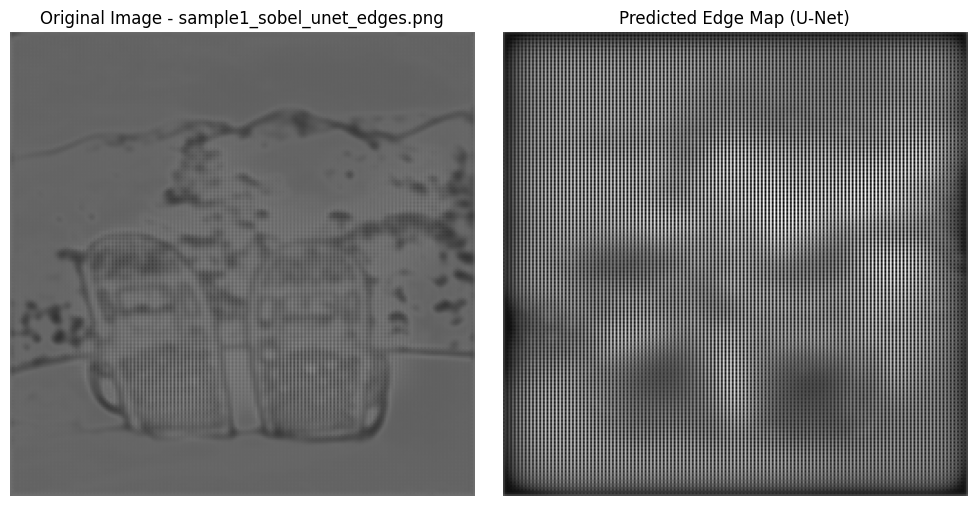

✅ Saved edge map to /Users/moh4n_ir/Downloads/edge-detection-assignment/notebooks/data/sample_images/sample1_sobel_unet_edges_unet_edges.png


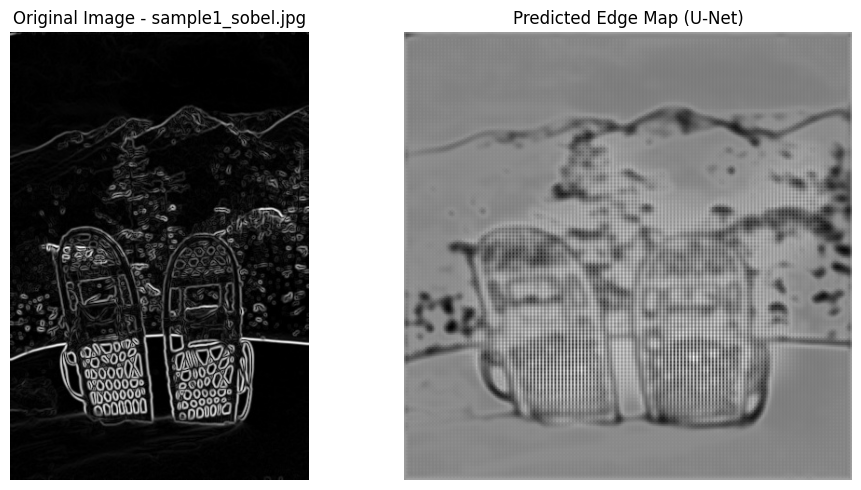

✅ Saved edge map to /Users/moh4n_ir/Downloads/edge-detection-assignment/notebooks/data/sample_images/sample1_sobel_unet_edges.png


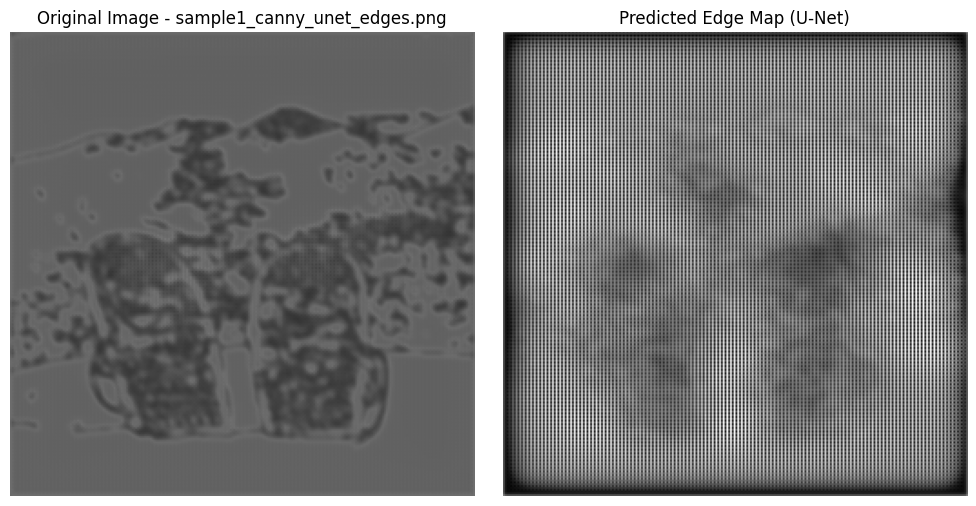

✅ Saved edge map to /Users/moh4n_ir/Downloads/edge-detection-assignment/notebooks/data/sample_images/sample1_canny_unet_edges_unet_edges.png


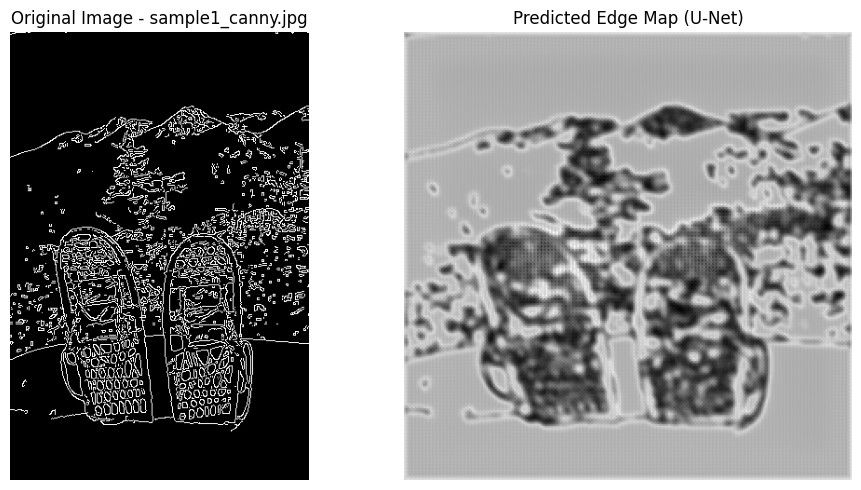

✅ Saved edge map to /Users/moh4n_ir/Downloads/edge-detection-assignment/notebooks/data/sample_images/sample1_canny_unet_edges.png


In [1]:
import os
import sys
import torch
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Add the parent directory of the 'unet' package to sys.path
# Adjust this path as necessary to point to "/Users/moh4n_ir/Downloads/edge-detection-assignment/models/pytorch_unet"
pytorch_unet_path = os.path.abspath("/Users/moh4n_ir/Downloads/edge-detection-assignment/models/pytorch_unet")
if pytorch_unet_path not in sys.path:
    sys.path.insert(0, pytorch_unet_path)

# Debugging: Print the added path
print(f"🔍 Checking U-Net package path: {pytorch_unet_path}")

# Import the U-Net model using an absolute import (package 'unet' is now discoverable)
try:
    from unet.unet_model import UNet  # Now the import should work since 'pytorch_unet' is in sys.path
except ModuleNotFoundError as e:
    print(f"❌ ModuleNotFoundError: {e}")
    print("⚠️ Make sure 'unet_model.py' exists in the 'unet' package directory.")
    sys.exit(1)

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained U-Net model
model_path = os.path.join(pytorch_unet_path, "trained_unet.pth")
if not os.path.exists(model_path):
    print(f"❌ Model file not found: {model_path}")
    print("⚠️ Make sure 'trained_unet.pth' exists in the 'models/pytorch_unet/' directory.")
    sys.exit(1)

model = UNet(n_channels=3, n_classes=1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
print("✅ U-Net model loaded successfully!")

# Define the directory for sample images
sample_image_dir = os.path.abspath("data/sample_images")
if not os.path.exists(sample_image_dir):
    print(f"❌ Sample image directory not found: {sample_image_dir}")
    sys.exit(1)

sample_images = [img for img in os.listdir(sample_image_dir) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
if not sample_images:
    print("⚠️ No images found in the sample image directory.")
    sys.exit(1)

# Define preprocessing transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match the model input size
    transforms.ToTensor()           # Convert image to tensor
])

# Process each test image
for img_name in sample_images:
    img_path = os.path.join(sample_image_dir, img_name)
    
    try:
        input_image = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"❌ Error loading image {img_name}: {e}")
        continue

    input_tensor = transform(input_image).unsqueeze(0).to(device)  # Add batch dimension

    # Model inference
    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.sigmoid(output)  # Apply sigmoid for binary mask
        edge_map = prediction.squeeze().cpu().numpy()

    # Visualize the result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title(f"Original Image - {img_name}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(edge_map, cmap='gray')
    plt.title("Predicted Edge Map (U-Net)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Save the edge map result with the corrected string literal
    output_save_path = os.path.join(sample_image_dir, f"{os.path.splitext(img_name)[0]}_unet_edges.png")
    edge_map_uint8 = (edge_map * 255).astype(np.uint8)
    cv2.imwrite(output_save_path, edge_map_uint8)
    print(f"✅ Saved edge map to {output_save_path}")
